# Finding Fraudsters 
**Group Project by:** Zamiul Alam, Alex Gekow, Kazi Aatish Imroz, Roshan Joshi, Kayode Oyedele \
Submitted as part of the Data Science Bootcamp by the Erdős Institute.

# Feature Engineering and Model Training

We import the necessary modules.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve,auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 150)

We read the 4 files provided in the competetion. The files are as follow: 
1. `id`= Dataset containing 41 id features for the training data
2. `tranz` = Dataset containing 394 transaction features for the training data
3. `id_test` = Dataset containing 41 id features for the test data
4. `tranz_test` = Dataset containing 394 transaction features for the test data

In [2]:
path1 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/train_identity.csv'
path2 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/train_transaction.csv'
path3 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/test_identity.csv'
path4 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/test_transaction.csv'

id = pd.read_csv(path1)
tranz = pd.read_csv(path2)
id_test = pd.read_csv(path3)
tranz_test = pd.read_csv(path4)

We perform the necessary steps to combine the id and transaction features for the training and test data.

In [3]:
#Replace '-' with '_' due to error in naming
id_test.columns = [col.replace('-', '_') for col in id_test.columns]

#Merge id and transaction data sets using TransactionID
tranz = tranz.merge(id, how='left', on='TransactionID')
tranz_test = tranz_test.merge(id_test, how = 'left', on = 'TransactionID')

#Create an empty isFraud column in the transaction test set
tranz_test['isFraud'] = np.nan

The best features for selected from extensive EDA by all the team members. They can either be read from the `.txt` file provided or from list included.

In [4]:
#Comment out to read from txt files
#transaction_features = pd.read_csv('/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/Transaction_features.txt', header=None)[0].tolist()
#id_features = pd.read_csv('/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/id_features.txt', header=None)[0].tolist()

transaction_features  = ['isFraud', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 
                         'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 
                         'P_emaildomain', 'R_emaildomain', 'C1', 'C3', 'C5', 'C7', 'C9', 'C13', 
                         'D1', 'D3', 'D4', 'D5', 'D10', 'D11', 'D13', 'D15', 'M3', 'M4', 'M5', 'M6', 'M8', 'M9', 
                         'V12', 'V20', 'V38', 'V44', 'V45', 'V53', 'V56', 'V62', 'V67', 'V81', 'V82', 'V83', 'V87',
                         'V99', 'V130', 'V165', 'V258', 'V261', 'V281', 'V282', 'V283', 'V285', 'V308', 'V309', 
                         'V310', 'V313', 'V314', 'V223', 'C4', 'C10', 'C12', 'V289', 'V86', 'C2', 'V26', 'C8', 'V108',
                         'V284', 'V279', 'V173', 'M1', 'V304', 'V37', 'V286', 'V98', 'V94', 'V288', 'V55', 'M7', 'V95', 
                         'V77', 'V125', 'C6', 'C11', 'C14', 'D2', 'M2', 'V1', 'V2', 'V6', 'V10', 'V14', 'V19', 'V23', 
                         'V25', 'V35', 'V39', 'V46', 'V61', 'V65', 'V66', 'V75', 'V88', 'V89', 'V107', 'V109', 'V115', 
                         'V117', 'V118', 'V120', 'V121', 'V123', 'V124', 'V135', 'V290', 'V300', 'V305', 'V319', 'V242', 
                         'V188', 'V172', 'V72', 'V70', 'V91', 'V156', 'V294']

id_features = ['id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_12', 'id_13', 'id_15', 'id_16', 'id_17', 
               'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 
               'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


features_to_keep = set(transaction_features + id_features)
features_to_keep = [col for col in tranz.columns if col in features_to_keep]

tranz = tranz[features_to_keep]
tranz_test = tranz_test[features_to_keep]

print('Number of selected features = ',len(tranz.columns))

Number of selected features =  156


We drop columns which have more than 80% of data as `nans`.

In [5]:
#Find the number of missing values in each column
miss_val_tranz = tranz.isnull().sum()

#Turn the missing value counts into percentages
miss_val_per_tranz = (miss_val_tranz/ len(tranz))*100

#Return counts and percentages of missing values in each column
miss_data_tranz = pd.DataFrame({'MIssing Values': miss_val_tranz,'Percentage (%)':miss_val_per_tranz})

print('Columns with 80 percent of non nan data:')
print(miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist())
print('Number of such columns = ',len(miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist()))

tranz = tranz[miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist()]
tranz_test= tranz_test[miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist()]

Columns with 80 percent of non nan data:
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V6', 'V10', 'V12', 'V14', 'V19', 'V20', 'V23', 'V25', 'V26', 'V35', 'V37', 'V38', 'V39', 'V44', 'V45', 'V46', 'V53', 'V55', 'V56', 'V61', 'V62', 'V65', 'V66', 'V67', 'V70', 'V72', 'V75', 'V77', 'V81', 'V82', 'V83', 'V86', 'V87', 'V88', 'V89', 'V91', 'V94', 'V95', 'V98', 'V99', 'V107', 'V108', 'V109', 'V115', 'V117', 'V118', 'V120', 'V121', 'V123', 'V124', 'V125', 'V130', 'V135', 'V172', 'V173', 'V188', 'V223', 'V242', 'V258', 'V261', 'V279', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V288', 'V289', 'V290', 'V294', 'V300', 'V304', 'V305', 'V308', 'V

We add useful features and change some data types

In [6]:
tranz["TransactionDay"] = np.floor(tranz["TransactionDT"] / (24*60*60))

for i in range(1,10):
    tranz["M"+str(i)] = tranz["M"+str(i)].astype(bool)

#Convert TransactionDT from seconds to day and make a new column
tranz_test["TransactionDay"] = np.floor(tranz_test["TransactionDT"] / (24*60*60))

In [7]:
#Create a universal id to dataset
tranz["D1n"] = tranz["TransactionDay"] - tranz["D1"]
tranz['uid'] = tranz["card1"].astype(str) + '_' + tranz["addr1"].astype(str) + '_' + tranz["D1n"].astype(str)

tranz_test["D1n"] = tranz_test["TransactionDay"] - tranz_test["D1"]
tranz_test['uid'] = tranz_test["card1"].astype(str) + '_' + tranz_test["addr1"].astype(str) + '_' + tranz_test["D1n"].astype(str)

In [8]:
print("Number of unique uid in tranz:", tranz['uid'].nunique())
print("Number of unique uid in tranz_test:", tranz_test['uid'].nunique())

common_uids = set(tranz['uid']).intersection(set(tranz_test['uid']))
print("Number of common uid in both tranz and tranz_test:", len(common_uids))

Number of unique uid in tranz: 217850
Number of unique uid in tranz_test: 196187
Number of common uid in both tranz and tranz_test: 27469


We see that `uid` identifies individuals from the Transaction data. We make two more features which helps identify individuals.

In [9]:
#Create features by combingin existing columns
tranz['card1_addr1'] = tranz["card1"].astype(str) + '_' + tranz["addr1"].astype(str)
tranz['card1_addr1_P_emaildomain'] = tranz['card1_addr1'] + '_' + tranz["P_emaildomain"].astype(str)

tranz_test['card1_addr1'] = tranz_test["card1"].astype(str) + '_' + tranz_test["addr1"].astype(str)
tranz_test['card1_addr1_P_emaildomain'] = tranz_test['card1_addr1'] + '_' + tranz_test["P_emaildomain"].astype(str)

We create a feature which counts the number of repeated transactions from the same user. Repeated transactions are more likely to be fraud.

In [10]:
# Step 1: Sort the DataFrame by time so we can check recent transactions efficiently
tranz = tranz.sort_values('TransactionDT').reset_index(drop=True)
tranz_test = tranz_test.sort_values('TransactionDT').reset_index(drop=True)

# Step 2: Create a unique key based on the three columns
tranz['key'] = (
    tranz['TransactionAmt'].astype(str) + '_' +
    tranz['ProductCD'].astype(str) + '_' +
    tranz['card1'].astype(str)
)
tranz_test['key'] = (
    tranz_test['TransactionAmt'].astype(str) + '_' +
    tranz_test['ProductCD'].astype(str) + '_' +
    tranz_test['card1'].astype(str)
)

# Create a boolean column 'key_match' indicating if the same key appears within 50 rows above or below
def add_key_match(df):
    key_arr = df['key'].values
    match = np.zeros(len(df), dtype=bool)
    for i in range(len(df)):
        start = max(0, i - 50)
        end = min(len(df), i + 51)
        window = np.r_[key_arr[start:i], key_arr[i+1:end]]
        if key_arr[i] in window:
            match[i] = True
    df['key_match'] = match

add_key_match(tranz)
add_key_match(tranz_test)

In [11]:
"""
Determines how many same keys occur in plus/minus 500 seconds around a given transaction
for both tranz and tranz_test
"""

# For tranz
tranz = tranz.sort_values('TransactionDT').reset_index(drop=True)
tranz['IsDuplicateInWindowz'] = 1

tds = np.asarray(tranz['TransactionDT'].values)
keys = np.asarray(tranz['key'].values)

for i in range(len(tranz)):
    lower = tds[i] - 500
    upper = tds[i] + 500
    start = np.searchsorted(tds, lower, side='left')
    end = np.searchsorted(tds, upper, side='right')
    window_keys = keys[start:end]
    match_count = np.sum(window_keys == keys[i])
    tranz.at[i, 'IsDuplicateInWindowz'] = match_count

# For tranz_test
tranz_test = tranz_test.sort_values('TransactionDT').reset_index(drop=True)
tranz_test['IsDuplicateInWindowz'] = 1

tds_test = np.asarray(tranz_test['TransactionDT'].values)
keys_test = np.asarray(tranz_test['key'].values)

for i in range(len(tranz_test)):
    lower = tds_test[i] - 500
    upper = tds_test[i] + 500
    start = np.searchsorted(tds_test, lower, side='left')
    end = np.searchsorted(tds_test, upper, side='right')
    window_keys = keys_test[start:end]
    match_count = np.sum(window_keys == keys_test[i])
    tranz_test.at[i, 'IsDuplicateInWindowz'] = match_count

The D Columns are "time deltas" from some point in the past. We will transform the D Columns into their point in the past. This will stop the D columns from increasing with time. The formula is `D1n = Transaction_Day - D1` and `Transaction_Day = TransactionDT/(24*60*60)`. Afterward we multiple this number by negative one.

In [12]:
#NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [6,7,8,9,12,13,14]: continue
    tranz['D'+str(i)] =  tranz['D'+str(i)] - tranz.TransactionDT/(24*60*60) 
    tranz_test['D'+str(i)] =  tranz_test['D'+str(i)] - tranz_test.TransactionDT/(24*60*60) 

We use 2 encoding functions: \
(1) `encode_AG` makes aggregated features such as aggregated mean and std \
(2) `encode_FE` does frequency encoding where it combines train and test first and then encodes.

In [ ]:
def encode_AG(tranz,groupby: str, aggregate_cols: list):
    """
    input:
    cols: list of features to frequency encode
    inplace: replace the columns with their frequency encoding. 
    output:
    dataframe with frequency encoded features
    """
    # Only use numeric columns for aggregation
    numeric_cols = [col for col in aggregate_cols if pd.api.types.is_numeric_dtype(tranz[col])]
    # Compute the mean and std for train
    means = tranz.groupby(groupby)[numeric_cols].transform('mean').add_suffix('_uid_mean')
    stds = tranz.groupby(groupby)[numeric_cols].transform('std').add_suffix('_uid_std')
    tranz = pd.concat([tranz, means, stds], axis=1)

    # Compute the mean and std for test using train group statistics
    group_means = tranz.groupby(groupby)[numeric_cols].mean()
    group_stds = tranz.groupby(groupby)[numeric_cols].std()
    for col in numeric_cols:
        tranz_test[f"{col}_uid_mean"] = tranz_test[groupby].map(group_means[col])
        tranz_test[f"{col}_uid_std"] = tranz_test[groupby].map(group_stds[col])

#Aggregate features
columns_to_encode = []
columns_to_encode += ["TransactionAmt", "TransactionDT", "addr1","addr2", "card1", "card2", "card3"]

encode_AG(tranz,'uid', columns_to_encode)

In [ ]:
def encode_FE(cols: list, inplace=False):
    """
    input:
    cols: list of features to frequency encode
    inplace: replace the columns with their frequency encoding. 
    output:
    dataframe with frequency encoded features
    """
    if isinstance(cols, str):
        cols = [cols]

    for col in cols:
        if inplace:
            col_name = col
        else:
            col_name = col + "_FE"
        # Combine both train and test for frequency calculation
        freq = pd.concat([tranz[col], tranz_test[col]]).value_counts(normalize=True)
        tranz[col_name] = tranz[col].map(freq)
        tranz_test[col_name] = tranz_test[col].map(freq)


#Frequency encode features
columns_to_encode = ["addr1","addr2", "card1", "card2", "card3", "P_emaildomain", "R_emaildomain",
                     'uid','card1_addr1','card1_addr1_P_emaildomain']

encode_FE(columns_to_encode)

We don't know the actual date from which the data was taken. But it is possible to create a random timestamp and keep track of the day of month and hour of day using `pd.to_datetime`.

In [15]:
#Create a day of the month and an hour of the day column
tranz['TransactionDTz'] = pd.to_datetime(tranz['TransactionDT'], unit='s', origin=pd.Timestamp('2000-01-01'))
tranz_test['TransactionDTz'] = pd.to_datetime(tranz_test['TransactionDT'], unit='s', origin=pd.Timestamp('2000-01-01'))

tranz['Day'] = tranz['TransactionDTz'].dt.day
tranz_test['Day'] = tranz_test['TransactionDTz'].dt.day

tranz['Hour'] = tranz['TransactionDTz'].dt.hour
tranz_test['Hour'] = tranz_test['TransactionDTz'].dt.hour

del tranz['TransactionDTz']
del tranz_test['TransactionDTz'] 

In the dataset, foreign transaction have three decimal places. So we try to recognize the foreign transactions.

In [16]:
tranz['TransactionAmt_third_decimal'] = tranz['TransactionAmt'].apply(lambda x: 'True' if round(x * 1000) % 10 != 0 else 'False')
tranz_test['TransactionAmt_third_decimal'] = tranz_test['TransactionAmt'].apply(lambda x: 'True' if round(x * 1000) % 10 != 0 else 'False')

We replace the nan values with -999 and use factorize on all the columns with type object and bool.

In [17]:
tranz = tranz.fillna(-999)
tranz_test = tranz_test.fillna(-999)

for col in tranz.select_dtypes(include=['object','bool']).columns:
    tranz[col], _ = pd.factorize(tranz[col])

for col in tranz_test.select_dtypes(include=['object','bool']).columns:
    tranz_test[col], _ = pd.factorize(tranz_test[col])

We drop  some of the columns which were used to make new features.

In [19]:
from sklearn.model_selection import train_test_split

y = tranz["isFraud"]
X = tranz.drop(columns=["isFraud","D1n",'key', "TransactionID",'TransactionDT','uid',"Day"]) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

We use 3 different models to train on the data. The models are: \
(1) XGBoost \
(2) LightGBM \
(3) CatBoost

## XGBoost

In [ ]:
print("XGBoost version:", xgb.__version__)

clf = xgb.XGBClassifier( 
    n_estimators=2000,
    max_depth=12, 
    learning_rate=0.02, 
    subsample=0.8,
    colsample_bytree=0.4, 
    eval_metric= 'aucpr',
    nthread=4,
    tree_method='hist',  # Use CPU if GPU is not available
    #tree_method='gpu_hist' # Use GPU if GPU is available
    early_stopping_rounds=10
)
h = clf.fit(X_train, y_train, 
    eval_set=[(X_test,y_test)],
    verbose=50)

XGBoost version: 3.0.2
[0]	validation_0-aucpr:0.46607
[50]	validation_0-aucpr:0.69936
[100]	validation_0-aucpr:0.75298
[150]	validation_0-aucpr:0.78692
[200]	validation_0-aucpr:0.80961
[250]	validation_0-aucpr:0.82591
[300]	validation_0-aucpr:0.83911
[350]	validation_0-aucpr:0.84901
[400]	validation_0-aucpr:0.85653
[450]	validation_0-aucpr:0.86269
[500]	validation_0-aucpr:0.86826
[550]	validation_0-aucpr:0.87281
[600]	validation_0-aucpr:0.87651
[650]	validation_0-aucpr:0.88041
[700]	validation_0-aucpr:0.88366
[750]	validation_0-aucpr:0.88679
[800]	validation_0-aucpr:0.88894
[850]	validation_0-aucpr:0.89128
[900]	validation_0-aucpr:0.89308
[950]	validation_0-aucpr:0.89475
[1000]	validation_0-aucpr:0.89625
[1050]	validation_0-aucpr:0.89778
[1100]	validation_0-aucpr:0.89914
[1150]	validation_0-aucpr:0.90059
[1200]	validation_0-aucpr:0.90161
[1250]	validation_0-aucpr:0.90262
[1300]	validation_0-aucpr:0.90380
[1350]	validation_0-aucpr:0.90461
[1400]	validation_0-aucpr:0.90518
[1450]	validat

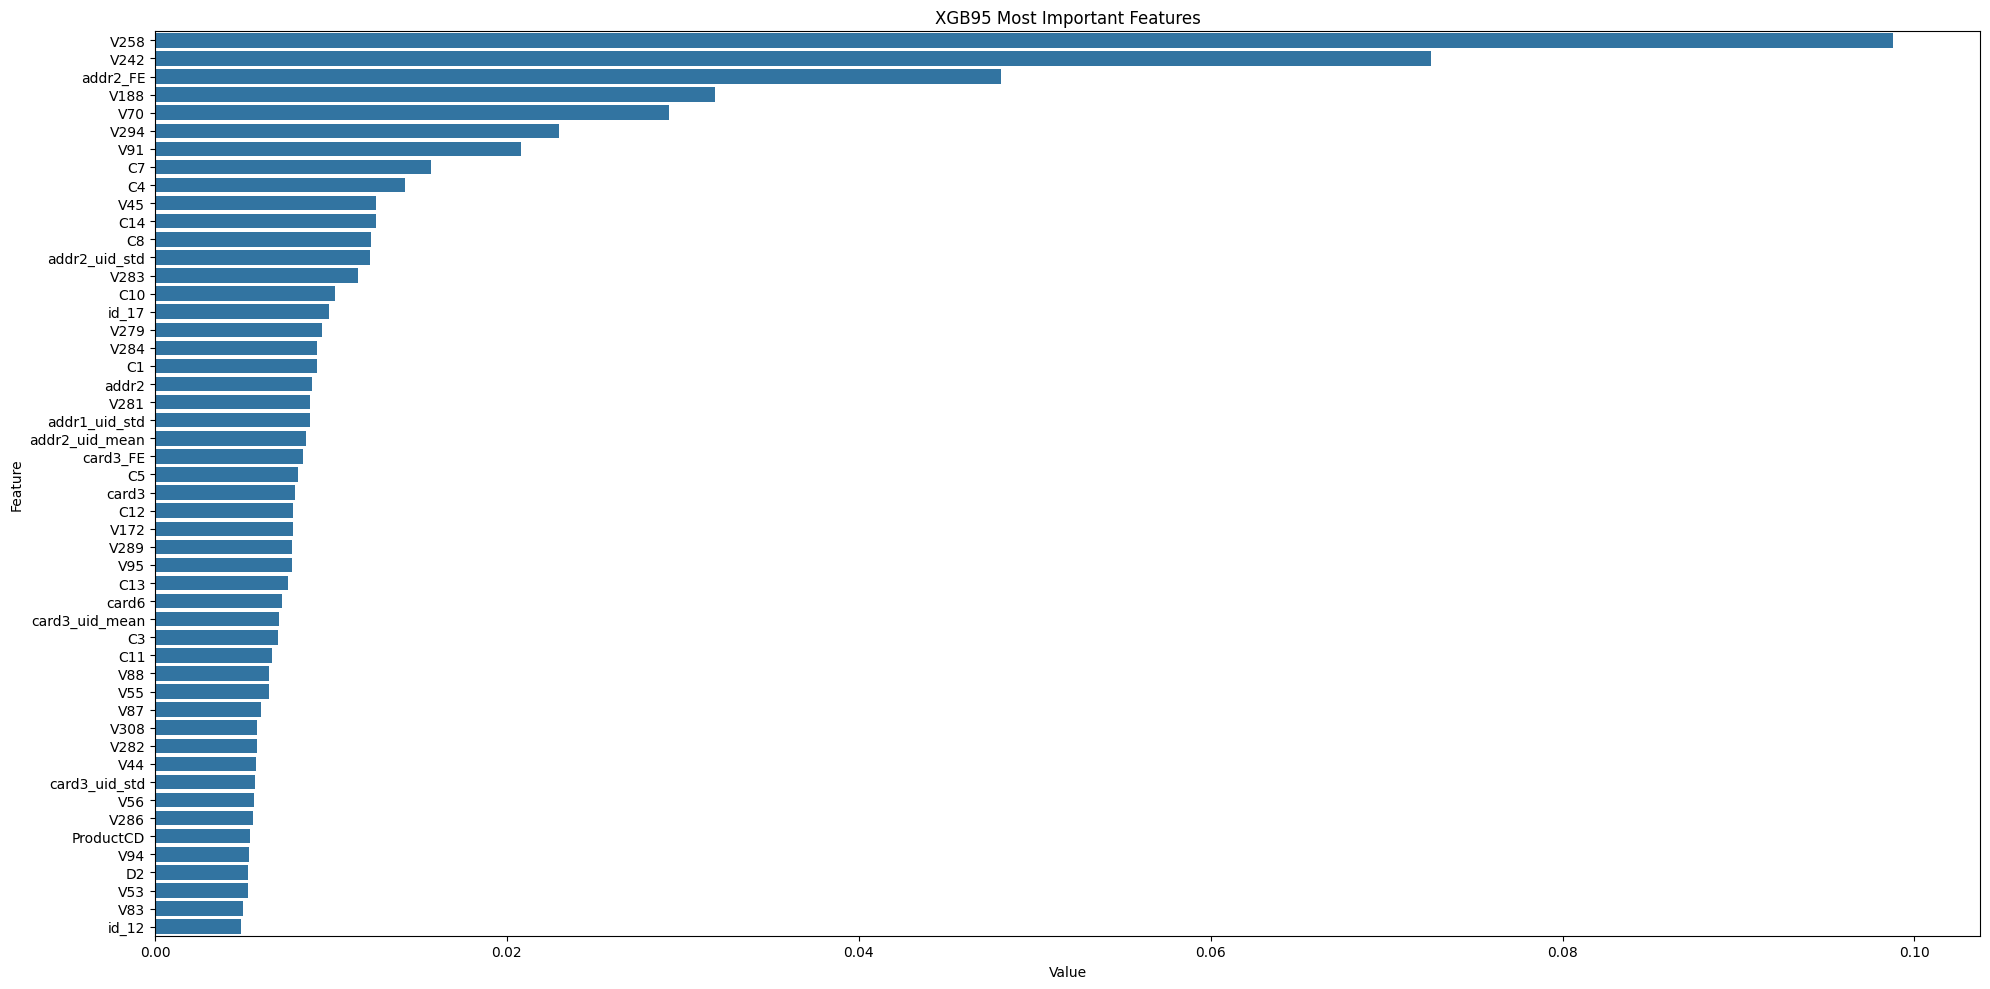

In [34]:
cols = X.columns.to_list()
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()

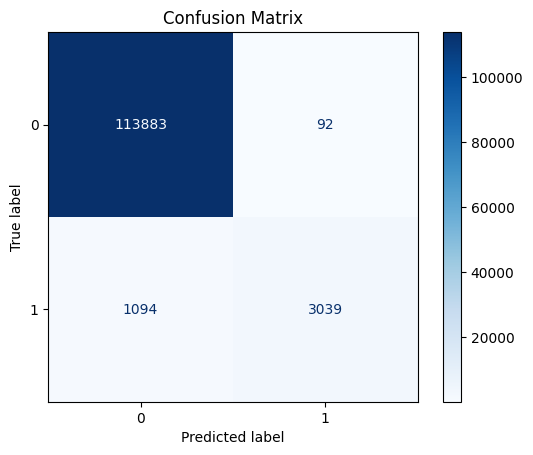

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels for the validation set
y_pred = clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

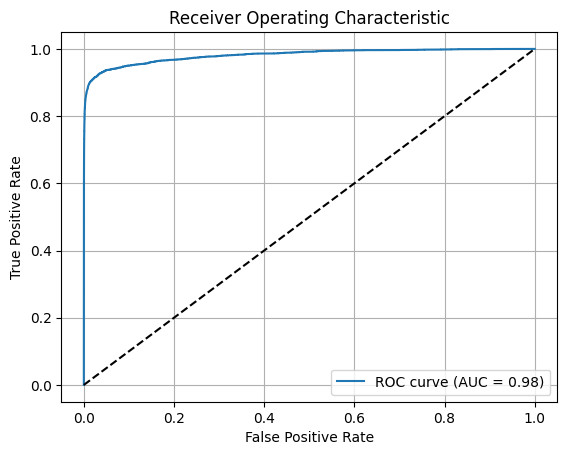

Best F1: 0.8752 at threshold: 0.1533
auc 0.910895634272756


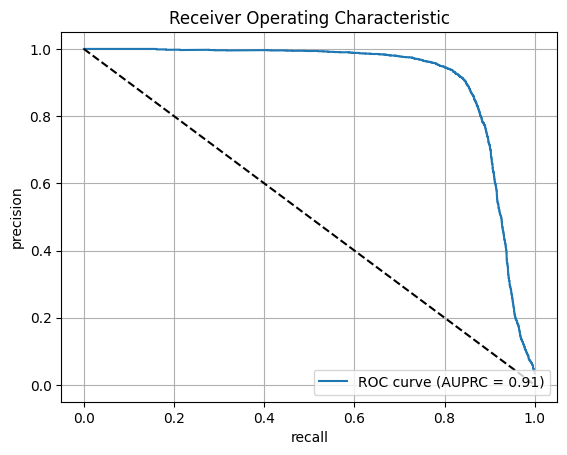

In [ ]:
# Get predicted probabilities for the positive class
y_probs = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, threshold = roc_curve(y_test.astype(int).values, y_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
# Compute ROC curve and AUC
precision, recall, threshold = precision_recall_curve(y_test.astype(int).values, y_probs)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]

best_index = np.argmax(f1_scores)
best_threshold = threshold[best_index]

roc_auc = auc(recall, precision)
print(f"Best F1: {f1_scores[best_index]:.4f} at threshold: {best_threshold:.4f}")
print("auc", roc_auc)
plt.figure()
plt.plot(recall,precision, label=f'ROC curve (AUPRC = {roc_auc:.2f})')
plt.plot([0, 1], [1, 0], 'k--')  # Diagonal line
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [38]:
# Predict probabilities for the test set
tranz_test_probs = clf.predict_proba(tranz_test[X_train.columns])[:, 1]

# Fill the isFraud column with predicted probabilities
tranz_test['isFraud'] = tranz_test_probs

tranz_test[['TransactionID', 'isFraud']].to_csv('sub_xg.csv', index=False)

#### AUC score on the test data from Kaggle:
#### private = 0.904536, public = 0.928511

## LightGBM

In [ ]:
print("LightGBM version:", lgb.__version__)

clf_lgbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    n_estimators=4000,
    max_depth=16,
    learning_rate=0.02,
    subsample=0.8,            # same as XGBoost’s subsample
    subsample_freq=1,         # ensure subsampling every tree
    colsample_bytree=0.4,     # same as XGBoost’s colsample_bytree
    n_jobs=4,                 # parallel threads
    # LightGBM auto-detects and handles missing values
)

h = clf_lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)]
)


LightGBM version: 4.6.0
[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16215
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 168
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101


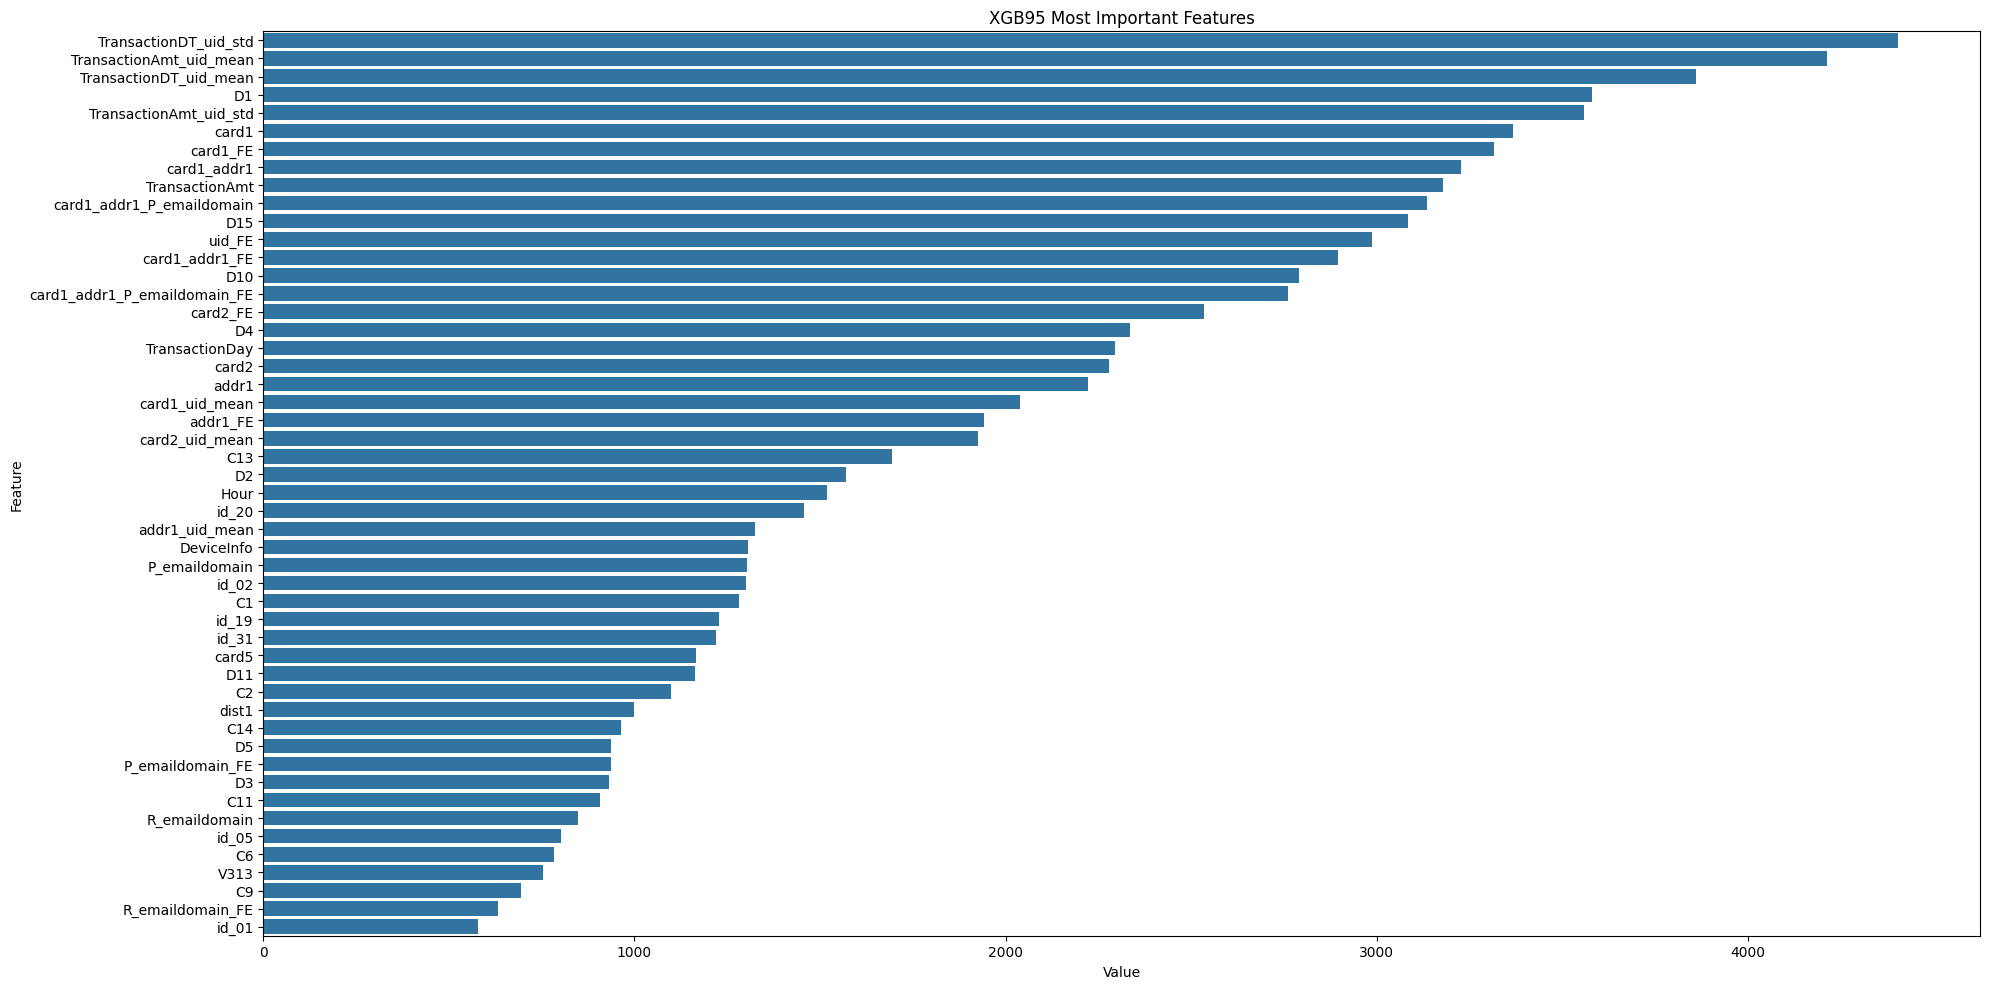

In [40]:
#cols = X.columns.to_list()
feature_imp = pd.DataFrame(sorted(zip(clf_lgbm.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
# Predict probabilities for the validation set
y_prob_lbm = clf_lgbm.predict_proba(X_test)[:, 1]

# Calculate AUPRC
auprc = average_precision_score(y_test, y_prob_lbm)
print("AUPRC:", auprc)

AUPRC: 0.8684886860884413


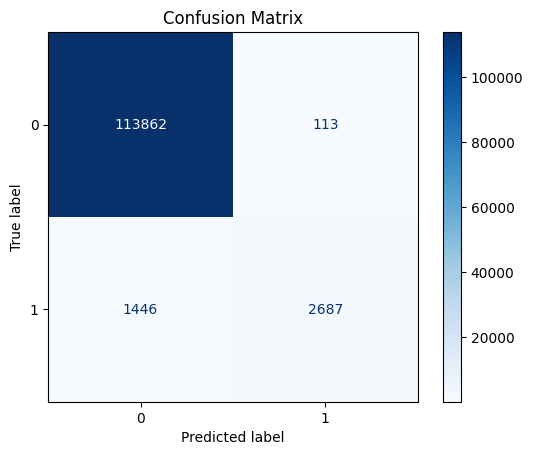

In [72]:
y_pred_lgbm = clf_lgbm.predict(X_test)

# Ensure predictions and true labels are 1D arrays
y_pred_lgbm = np.asarray(y_pred_lgbm).ravel()
y_test_flat = np.asarray(y_test).ravel()

# Compute confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_lgbm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

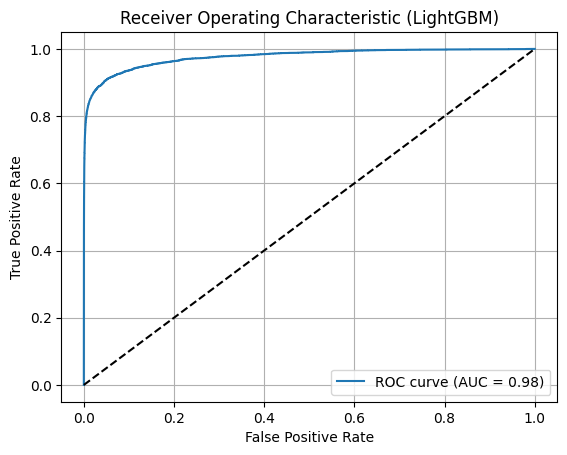

Best F1: 0.8260 at threshold: 0.2541
AUPRC: 0.8684800336078506


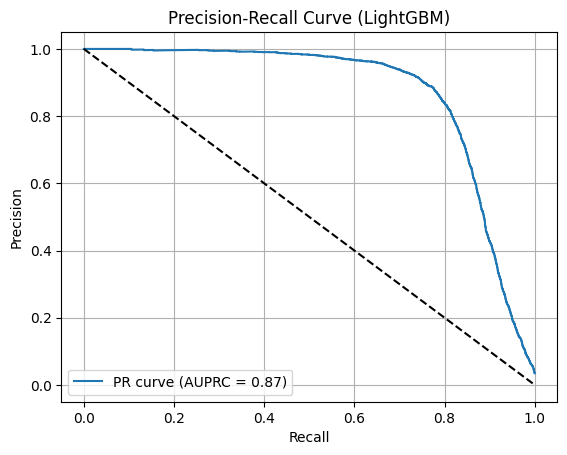

In [ ]:
# Get predicted probabilities for the positive class
y_prob_lbm = clf_lgbm.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test.astype(int).values, y_prob_lbm)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (LightGBM)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, thresholds_pr = precision_recall_curve(y_test.astype(int).values, y_prob_lbm)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_index]
auprc = auc(recall, precision)

print(f"Best F1: {f1_scores[best_index]:.4f} at threshold: {best_threshold:.4f}")
print("AUPRC:", auprc)
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUPRC = {auprc:.2f})')
plt.plot([0, 1], [1, 0], 'k--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (LightGBM)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [45]:
#tranz_test_probs_lgbm = clf_lgbm.predict_proba((tranz_test[X_train.columns])[:, 1])
tranz_test_probs_lgbm = clf_lgbm.predict_proba(tranz_test[X_train.columns])[:, 1]

# Fill the isFraud column with predicted probabilities
tranz_test['isFraud'] = tranz_test_probs_lgbm

tranz_test[['TransactionID', 'isFraud']].to_csv('sub_lgbm.csv', index=False)

#### AUC score on the test data from Kaggle:
#### private = 0.896420, public = 0.925167

## CATBoost

In [ ]:
clf_cb = CatBoostClassifier(
    iterations=3000,    
    depth=16,            
    learning_rate=0.02,
    subsample=0.8,       
    rsm=0.4,             
    verbose=100,         
    early_stopping_rounds=50
)

clf_cb.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
  
    use_best_model=True
)

0:	learn: 0.6557690	test: 0.6558571	best: 0.6558571 (0)	total: 2.15s	remaining: 1h 47m 45s
100:	learn: 0.0806739	test: 0.0869961	best: 0.0869961 (100)	total: 2m 44s	remaining: 1h 18m 53s
200:	learn: 0.0543967	test: 0.0679310	best: 0.0679310 (200)	total: 6m	remaining: 1h 23m 39s
300:	learn: 0.0437069	test: 0.0607710	best: 0.0607710 (300)	total: 9m 26s	remaining: 1h 24m 42s
400:	learn: 0.0362537	test: 0.0558332	best: 0.0558332 (400)	total: 12m 53s	remaining: 1h 23m 33s
500:	learn: 0.0308053	test: 0.0524869	best: 0.0524869 (500)	total: 16m 31s	remaining: 1h 22m 25s
600:	learn: 0.0263468	test: 0.0499541	best: 0.0499541 (600)	total: 19m 55s	remaining: 1h 19m 31s
700:	learn: 0.0227159	test: 0.0479245	best: 0.0479245 (700)	total: 23m 16s	remaining: 1h 16m 20s
800:	learn: 0.0198819	test: 0.0464774	best: 0.0464774 (800)	total: 26m 43s	remaining: 1h 13m 20s
900:	learn: 0.0175937	test: 0.0453200	best: 0.0453200 (900)	total: 30m 17s	remaining: 1h 10m 33s
1000:	learn: 0.0158000	test: 0.0445103	best

In [47]:
y_prob_cb = clf_cb.predict_proba(X_test)[:, 1]

# Calculate AUPRC
auprc = average_precision_score(y_test, y_prob_cb)
print("AUPRC:", auprc)

AUPRC: 0.892720803749502


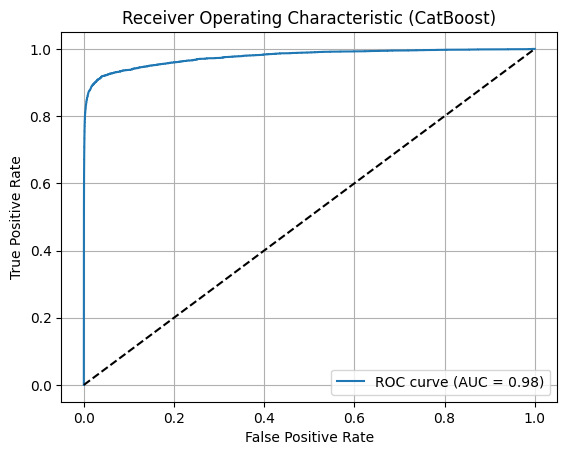

Best F1: 0.8564 at threshold: 0.1539
AUPRC: 0.8927145101228888


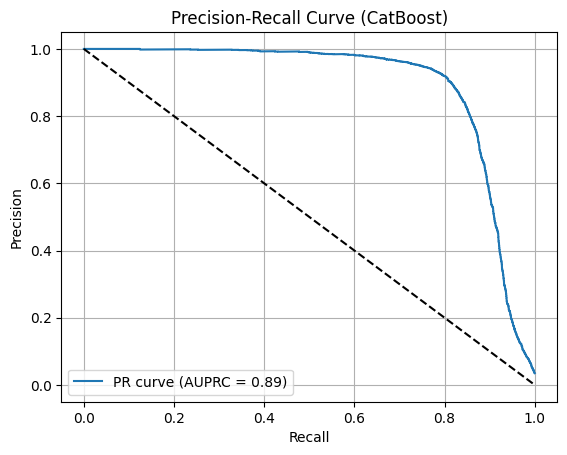

In [ ]:
# Get predicted probabilities for the positive class
y_prob_cb = clf_cb.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test.astype(int).values, y_prob_cb)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (CatBoost)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

precision, recall, thresholds_pr = precision_recall_curve(y_test.astype(int).values, y_prob_cb)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_index]
auprc = auc(recall, precision)

print(f"Best F1: {f1_scores[best_index]:.4f} at threshold: {best_threshold:.4f}")
print("AUPRC:", auprc)
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUPRC = {auprc:.2f})')
plt.plot([0, 1], [1, 0], 'k--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CatBoost)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [48]:
tranz_test_probs_cb = clf_cb.predict_proba(tranz_test[X_train.columns])[:, 1]

# Fill the isFraud column with predicted probabilities
tranz_test['isFraud'] = tranz_test_probs_cb

tranz_test[['TransactionID', 'isFraud']].to_csv('sub_cb.csv', index=False)

#### AUC score on the test data from Kaggle:
#### private = 0.889827, public = 0.913809

In [68]:
# Average predictions from XGBoost, LightGBM, and CatBoost
tranz_test['isFraud'] = (
    tranz_test_probs + tranz_test_probs_cb + tranz_test_probs_lgbm 
) / 3

# Save the averaged predictions
tranz_test[['TransactionID', 'isFraud']].to_csv('sub_ensemble_avg.csv', index=False)

#### AUC score on the test data from Kaggle:
#### private = 0.903449, public = 0.930096

In [ ]:
# Weighted Average predictions from XGBoost, LightGBM, and CatBoost
tranz_test['isFraud'] = (
    0.7*tranz_test_probs + 0.1*tranz_test_probs_lgbm + 0.2*tranz_test_probs_cb
)

# Save the averaged predictions
tranz_test[['TransactionID', 'isFraud']].to_csv('sub_ensemble_weighted.csv', index=False)

#### AUC score on the test data from Kaggle:
#### private = 0.907120, public = 0.932722